In [1]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression,Lasso,Ridge,ElasticNet
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import TargetEncoder,FunctionTransformer

In [2]:
import pandas as pd
import numpy as np

In [3]:
df = pd.read_csv('../data/cleaned_dataset.csv')

In [4]:
# target feature and redundant features to be dropped 

target_feature = 'Time_taken (min)'
drop_features = ['ID', 'Time_Orderd', 'Order_Date', 'Type_of_order', target_feature]

In [5]:
numerical_columns = ['Delivery_person_Age', 'Delivery_person_Ratings', 
                     "Restaurant_latitude", "Restaurant_longitude", "Delivery_location_latitude", "Delivery_location_longitude", 'Time_Order_picked']
categorical_columns = ['Weather_conditions', 'Road_traffic_density', 'Vehicle_condition', 'Type_of_vehicle', 'multiple_deliveries',	'Festival', 'City']

In [6]:
Weather_conditions_map={'Fog':3,'Cloudy':3,'Stormy':2,'Sandstorms':2,'Windy':2,'Sunny':1}
Road_traffic_density_map={'Jam':4, 'High':3, 'Medium':2, 'Low':1}
Type_of_vehicle_map={'motorcycle':2, 'bicycle':2, 'scooter':1, 'electric_scooter':1}
Festival_map={'Yes':1, 'No':0}
City_map={'Semi-Urban':3, 'Metropolitian':2, 'Urban':1}

In [7]:
from geopy.distance import geodesic

In [8]:
class timeDist_transform:
    coordinates = ["Restaurant_latitude", "Restaurant_longitude", 
                    "Delivery_location_latitude", "Delivery_location_longitude"]
    
    def _geo(self, sample):
        if sample.notnull().all():
            return geodesic(
                    (sample["Restaurant_latitude"], sample["Restaurant_longitude"]), 
                    (sample["Delivery_location_latitude"], sample["Delivery_location_longitude"])).km
        else:
            return np.nan    # passing as NaN if any coordinate is null

    
    def timeDist(self, df: pd.DataFrame):
        """function to convert coordinates to distance in kilometres"""

        df["Distance"] = df.apply(self._geo, axis=1) 
        df = df.drop(columns=self.coordinates)
        df['Time_Order_picked'] = pd.to_datetime(df['Time_Order_picked'], errors='coerce', format='%H:%M').dt.hour
        return df


    def feature_names(self, _, feature_names):
        features  = [i for i in feature_names if i not in self.coordinates]
        features.append('Distance')
        return features

In [9]:
def mapper(df :pd.DataFrame):
    '''mapping function for the categorical columns'''

    df['Weather_conditions'] = df['Weather_conditions'].map(Weather_conditions_map)
    df['Road_traffic_density'] = df['Road_traffic_density'].map(Road_traffic_density_map)
    df['Type_of_vehicle'] = df['Type_of_vehicle'].map(Type_of_vehicle_map)
    df['Festival'] = df['Festival'].map(Festival_map)
    df['City'] = df['City'].map(City_map)
    return df

In [10]:
# Delivery person ID pipeline
id_pipeline = Pipeline(
    steps=[
        ('target_encoder_id', TargetEncoder(target_type='continuous')),
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ]
)

# Numerical pipeline
timeDist = timeDist_transform()
numerical_pipeline = Pipeline(
    steps=[
        ('time_distance', FunctionTransformer(timeDist.timeDist,
                                              feature_names_out = timeDist.feature_names)),
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]
)

# categorical pipeline
categorical_pipeline = Pipeline(
    steps=[
        ('mapper', FunctionTransformer(mapper, feature_names_out='one-to-one')),
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('scaler', StandardScaler())
    ]
)

preprocessor = ColumnTransformer([
    ('id', id_pipeline, ['Delivery_person_ID']),
    ('num_pipe', numerical_pipeline, numerical_columns),
    ('cat_pipe', categorical_pipeline, categorical_columns)
])

In [11]:
# train test split
train_df, test_df = train_test_split(df, test_size=0.30, random_state=3)

In [12]:
X_train = train_df.drop(columns=drop_features)
y_train = train_df[target_feature]

X_test = test_df.drop(columns=drop_features)
y_test = test_df[target_feature]

In [13]:
X_train = pd.DataFrame(preprocessor.fit_transform(X_train, y=y_train), columns=preprocessor.get_feature_names_out())
X_test = pd.DataFrame(preprocessor.transform(X_test), columns=preprocessor.get_feature_names_out())

In [14]:
X_train.head()

,id__Delivery_person_ID,num_pipe__Delivery_person_Age,num_pipe__Delivery_person_Ratings,num_pipe__Time_Order_picked,num_pipe__Distance,cat_pipe__Weather_conditions,cat_pipe__Road_traffic_density,cat_pipe__Vehicle_condition,cat_pipe__Type_of_vehicle,cat_pipe__multiple_deliveries,cat_pipe__Festival,cat_pipe__City
0,-0.038611,-0.453229,0.855546,0.986695,0.489118,-0.258872,-1.095892,-1.225324,0.851462,-1.330184,-0.141143,-1.858024
1,-2.086062,-0.099473,1.180473,1.220803,1.912910,-0.258872,-1.095892,-0.030284,0.851462,0.442337,-0.141143,-1.858024
2,-1.902647,0.077405,-0.119237,-1.822603,-1.219380,1.212181,-1.095892,-0.030284,0.851462,0.442337,-0.141143,0.514611
3,0.239798,0.784917,0.855546,0.284370,0.774445,1.212181,1.307984,-1.225324,0.851462,2.214859,-0.141143,0.514611
4,0.725606,0.961795,0.530618,0.986695,0.774379,-0.258872,-1.095892,-0.030284,-1.174450,0.442337,-0.141143,0.514611


In [15]:
X_test.head()

,id__Delivery_person_ID,num_pipe__Delivery_person_Age,num_pipe__Delivery_person_Ratings,num_pipe__Time_Order_picked,num_pipe__Distance,cat_pipe__Weather_conditions,cat_pipe__Road_traffic_density,cat_pipe__Vehicle_condition,cat_pipe__Type_of_vehicle,cat_pipe__multiple_deliveries,cat_pipe__Festival,cat_pipe__City
0,-0.602812,-0.983863,0.855546,0.986695,-0.921762,-1.729925,-1.095892,-0.030284,0.851462,0.442337,-0.141143,0.514611
1,-0.517049,0.254283,0.205690,-2.290819,-1.215479,1.212181,-1.095892,-0.030284,0.851462,0.442337,-0.141143,0.514611
2,0.399228,-0.099473,0.205690,0.050262,-0.357581,-1.729925,-0.294600,-0.030284,-1.174450,0.442337,-0.141143,-1.858024
3,0.234616,0.961795,0.205690,-0.886170,-0.668092,-1.729925,0.506692,-0.030284,-1.174450,-1.330184,-0.141143,0.514611
4,-0.537135,0.077405,-1.094020,-0.183846,0.771638,1.212181,-0.294600,-0.030284,0.851462,0.442337,-0.141143,0.514611


In [16]:
def model_evaluation(true, predicted):
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(true, predicted)
    r2_squared = r2_score(true, predicted)
    return rmse, mae, r2_squared

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

In [18]:
import warnings
warnings.filterwarnings('ignore')

Model Training Performance
Model Name: LinearRegression
RMSE: 6.185760936208517
MAE: 4.893528570476264
Test R2 score: 56.70634654220934
Train R2 score: 57.08532273384896


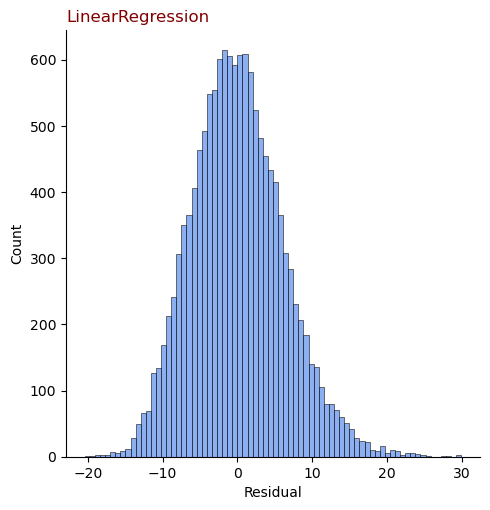


Model Training Performance
Model Name: Lasso
RMSE: 6.68093988687665
MAE: 5.31497837414664
Test R2 score: 49.49747392786791
Train R2 score: 49.928895330918586


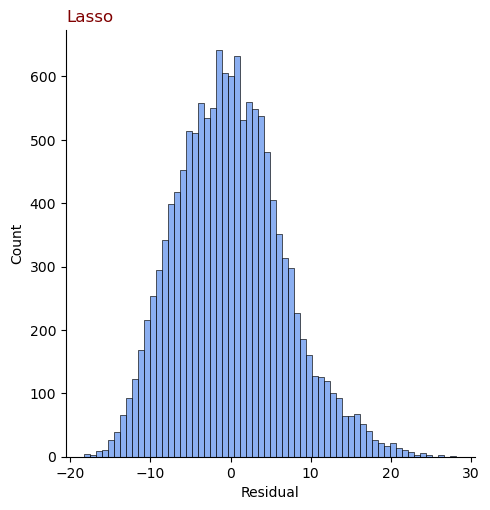


Model Training Performance
Model Name: Ridge
RMSE: 6.185761680317135
MAE: 4.8935296257032075
Test R2 score: 56.70633612629352
Train R2 score: 57.08532269932649


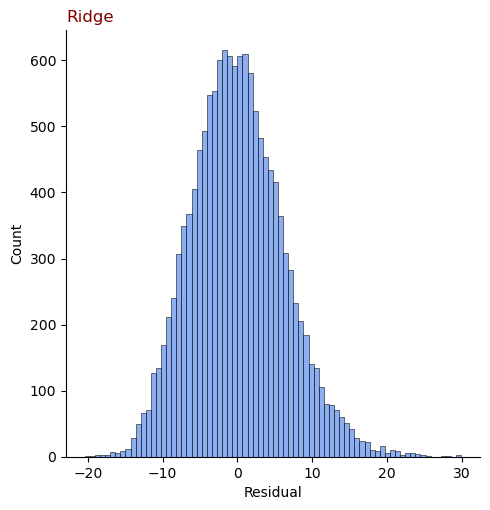


Model Training Performance
Model Name: ElasticNet
RMSE: 6.750876608536838
MAE: 5.3922510649219
Test R2 score: 48.434609202775
Train R2 score: 48.811505433387715


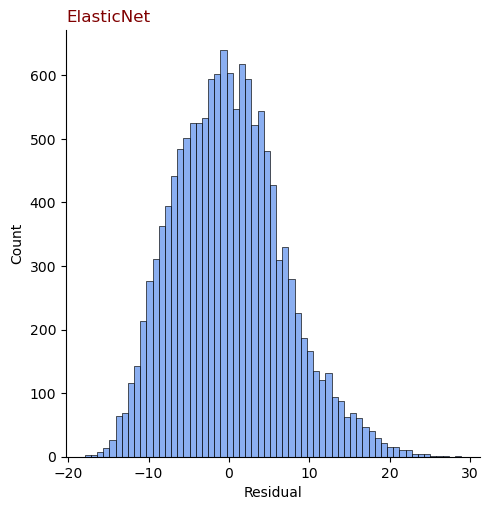

In [19]:
# Training multiple models

models = {
    'LinearRegression' : LinearRegression(),
    'Lasso' : Lasso(),
    'Ridge' : Ridge(),
    'ElasticNet' : ElasticNet()
}

for i in models:
    model = models[i]
    model.fit(X_train, y_train)

    # predictions
    y_pred = model.predict(X_test)

    rmse, mae, r2_squared = model_evaluation(y_test, y_pred)

    print('Model Training Performance')
    print(f'Model Name: {i}')
    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")
    print(f"Test R2 score: {r2_squared*100}")
    print(f"Train R2 score: {model.score(X_train,y_train)*100}")

    res=y_test-y_pred

    sns.displot(res, color='cornflowerblue')
    plt.xlabel('Residual')
    plt.title(i, loc='left', color='maroon')
    plt.show()
    
    print('='*100,'\n')

In [20]:
# The resuduals of the models are distributed normally, which indicates a completed model

In [21]:
# Ordinary linear regression has the best r2 score
regression = LinearRegression()
regression.fit(X_train, y_train)

LinearRegression()

In [22]:
for i,j in zip(regression.feature_names_in_, regression.coef_):
    print(f'{i} : {j}')
print(f'intercept : {regression.intercept_}')

id__Delivery_person_ID : 0.010912367721645763
num_pipe__Delivery_person_Age : 2.215028532275904
num_pipe__Delivery_person_Ratings : -2.23305869688686
num_pipe__Time_Order_picked : -0.49826738221661765
num_pipe__Distance : 2.0188207535397216
cat_pipe__Weather_conditions : 2.052672688660265
cat_pipe__Road_traffic_density : 2.8678319784723554
cat_pipe__Vehicle_condition : -1.4890017317961102
cat_pipe__Type_of_vehicle : 0.28643019814784376
cat_pipe__multiple_deliveries : 1.7287985746247667
cat_pipe__Festival : 1.418208019433299
cat_pipe__City : 0.9605291973183729
intercept : 26.289747213063272
